In [0]:
#FULL RESTART
#!kill -9 -1

# 20181116 SHAP

Use of SHAP on the OpenFoodFact DataBase in order to explain the new prediction model (Random Forest).

# SHAP install

In [0]:
!pip install shap

# Import

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import operator

import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from google.colab import files
import zipfile

# Zip import from local folder

---> fr.openfoodfacts.org.products.csv.zip

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving fr.openfoodfacts.org.products.csv.zip to fr.openfoodfacts.org.products.csv.zip
User uploaded file "fr.openfoodfacts.org.products.csv.zip" with length 88117814 bytes


# Function

In [0]:
#Create folders
def folder_create(path):
    os.makedirs(os.path.join(path), exist_ok=True)

# Dataset preparation

## Folder creation

In [0]:
# Folder creation
folder_create('raw')
folder_create('clean')

## Downloading

In [7]:
!ls

clean  fr.openfoodfacts.org.products.csv.zip  raw  sample_data


In [0]:
zip_ref = zipfile.ZipFile('fr.openfoodfacts.org.products.csv.zip', 'r')
zip_ref.extractall('raw/')
zip_ref.close()

In [9]:
data_nutri_raw = pd.read_csv(
    'raw/fr.openfoodfacts.org.products.csv', 
    sep='\t', 
    encoding='utf-8', 
    low_memory = False)

pd.options.display.max_columns=165
data_nutri_raw.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [10]:
shape = data_nutri_raw.shape
shape

print("This database contains",shape[0], 
      "products described with", shape[1], "parameters (with empty values).")

This database contains 320772 products described with 162 parameters (with empty values).


In [11]:
# Dropna axe 1
data_nutri_raw_test = data_nutri_raw.dropna(axis=1, thresh = 196935)    # 196935 = 60%
data_nutri_raw_test.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'brands_tags', 'countries', 'countries_tags', 'countries_fr',
       'ingredients_text', 'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states', 'states_tags', 'states_fr', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

*   'code', 
*   'url', 
*   'creator', 
*   'created_t',
*   'created_datetime',
*   'last_modified_t',
*   'last_modified_datetime', 
*   'product_name', 
*   'brands',
*   'brands_tags',
*   'countries',
*   'countries_tags',
*   'countries_fr',
*   'ingredients_text', 
*   'serving_size',
*   'additives_n',
*   'additives',
*   'ingredients_from_palm_oil_n',
*   'ingredients_that_may_be_from_palm_oil_n', 
*   'nutrition_grade_fr',
*   'states', 
*   'states_tags', 
*   'states_fr', 
*   'energy_100g', 
*   'fat_100g',
*   'saturated-fat_100g', 
*   'carbohydrates_100g', 
*   'sugars_100g', 
*   'fiber_100g',
*   'proteins_100g', 
*   'salt_100g', 
*   'sodium_100g',
*   'nutrition-score-fr_100g',
*   'nutrition-score-uk_100g'

In [0]:
data_nutri_clean = pd.DataFrame(data_nutri_raw,
                                columns = ['code',
#'url',
#'creator',
#'created_t',
#'created_datetime',
#'last_modified_t',
#'last_modified_datetime',
'product_name', 
#'generic_name',
#'quantity',
#'packaging : shape, material',
#'packaging_tags',
#'brands',
#'brands_tags',
#'categories',
#'categories_tags',
#'categories_fr',
#'origins : origins of ingredients',
#'origins_tags',
#'manufacturing_places : places where manufactured or transformed',
#'manufacturing_places_tags',
#'labels',
#'labels_tags',
#'labels_fr',
#'emb_codes',
#'emb_codes_tags', 
#'first_packaging_code_geo : coordinates corresponding to the first packaging code indicated',
#'cities',
#'cities_tags',
#'purchase_places',
#'stores',
#'countries : list of countries where the product is sold',
#'countries_tags',
#'countries_fr'
 
                                           
# ingredients:
             
# 'ingredients_text',
# 'traces',
# 'traces_tags',

                                           
# misc. data:
             
#'serving_size : serving size in g',
#'no_nutriments : indicates if the nutrition facts are indicated on the food label',
'additives_n', # : number of food additives',
#'additives',
'additives_tags',
'ingredients_from_palm_oil_n',
#'ingredients_from_palm_oil',
#'ingredients_from_palm_oil_tags',
'ingredients_that_may_be_from_palm_oil_n',
#'ingredients_that_may_be_from_palm_oil',
#'ingredients_that_may_be_from_palm_oil_tags',
#'nutrition_grade_fr : (a to e) see http://fr.openfoodfacts.org/score-nutritionnel-experimental-france',
'nutrition_grade_fr',
#'main_category',
#'main_category_fr',
#'image_url',
#'image_small_url',
   
                                           
# nutrition facts:
             
'energy_100g',
'proteins_100g',
#'casein_100g',
#'serum-proteins_100g',
#'nucleotides_100g',                                          
'carbohydrates_100g', # regroupe les sucres, glucose, amidon
'sugars_100g',
#'sucrose_100g',
#'glucose_100g',
#'fructose_100g',
#'lactose_100g',
#'maltose_100g',
#'maltodextrins_100g',
#'starch_100g',                         
#'polyols_100g',
'fat_100g',
'saturated-fat_100g',
#'butyric-acid_100g',
#'caproic-acid_100g',
#'caprylic-acid_100g',
#'capric-acid_100g',
#'lauric-acid_100g',
#'myristic-acid_100g',
#'palmitic-acid_100g',
#'stearic-acid_100g',
#'arachidic-acid_100g',
#'behenic-acid_100g',
#'lignoceric-acid_100g',
#'cerotic-acid_100g',
#'montanic-acid_100g',
#'melissic-acid_100g',
'monounsaturated-fat_100g',
'polyunsaturated-fat_100g',
'omega-3-fat_100g',
#'alpha-linolenic-acid_100g',
#'eicosapentaenoic-acid_100g',
#'docosahexaenoic-acid_100g',
#'omega-6-fat_100g',
#'linoleic-acid_100g',
#'arachidonic-acid_100g',
#'gamma-linolenic-acid_100g',
#'dihomo-gamma-linolenic-acid_100g',
#'omega-9-fat_100g',
#'oleic-acid_100g',
#'elaidic-acid_100g',
#'gondoic-acid_100g',
#'mead-acid_100g',
#'erucic-acid_100g',
#'nervonic-acid_100g',
'trans-fat_100g',
'cholesterol_100g',
'fiber_100g',
'salt_100g',                                
'sodium_100g',
#'alcohol_100g : % vol of alcohol',
'vitamin-a_100g',
'vitamin-d_100g',
'vitamin-e_100g',
'vitamin-k_100g',
'vitamin-c_100g',
'vitamin-b1_100g',
'vitamin-b2_100g',
'vitamin-pp_100g', # vit b3
'vitamin-b6_100g',
'vitamin-b9_100g',
'vitamin-b12_100g',
'biotin_100g',      # vita b8
'pantothenic-acid_100g', # vitamine b5
#'silica_100g',
#'bicarbonate_100g',
'potassium_100g',
'chloride_100g',
'calcium_100g',
'phosphorus_100g',
'iron_100g',
'magnesium_100g',
'zinc_100g',
'copper_100g',
'manganese_100g',
'fluoride_100g',
'selenium_100g',
'chromium_100g',
'molybdenum_100g',
'iodine_100g',
#'caffeine_100g',
#'taurine_100g',
#'ph_100g : pH (no unit)',
#'fruits-vegetables-nuts_100g : % of fruits, vegetables and nuts (excluding potatoes, yams, manioc)',
#'carbon-footprint_100g : carbon footprint (indicated on some products)',
#'nutrition-score-fr_100g : experimental nutrition score derived from the UK FSA score and adapted for the French market (formula defined by the team of Professor Hercberg)',
'nutrition-score-fr_100g',                                         
#'nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (FSA) ',                                            
                                          ])                         


In [0]:
# Dropna axe 1
data_nutri_clean_dropna = data_nutri_clean.dropna(axis=1, thresh = 196935)    # 196935 = 60%

In [0]:
# Dropna Axe 0
data_nutri_light = data_nutri_clean_dropna.dropna(axis = 0 , subset=['sugars_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['saturated-fat_100g'])
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['fat_100g'])
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['energy_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['proteins_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['fiber_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['salt_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['ingredients_from_palm_oil_n'])
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['ingredients_that_may_be_from_palm_oil_n']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['carbohydrates_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['sodium_100g']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['additives_n']) 
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['nutrition-score-fr_100g'])
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['nutrition_grade_fr']) 

In [15]:
# Cette base light base mesure
shape = data_nutri_light.shape
shape

print("This database contains",shape[0], 
      "products described with", shape[1], "parameters (with empty values).")

This database contains 170540 products described with 16 parameters (with empty values).


In [0]:
data_nutri_light['sugars_100g'] = data_nutri_light['sugars_100g'].clip(0,100)
data_nutri_light['saturated-fat_100g'] = data_nutri_light['saturated-fat_100g'].clip(0,100)
data_nutri_light['fat_100g'] = data_nutri_light['fat_100g'].clip(0,100)
data_nutri_light['energy_100g'] = data_nutri_light['energy_100g'].clip(0,4000)
data_nutri_light['proteins_100g'] = data_nutri_light['proteins_100g'].clip(0,100)
data_nutri_light['fiber_100g'] = data_nutri_light['fiber_100g'].clip(0,100)
data_nutri_light['salt_100g'] = data_nutri_light['salt_100g'].clip(0,100)
data_nutri_light['carbohydrates_100g'] = data_nutri_light['carbohydrates_100g'].clip(0,100)
data_nutri_light['sodium_100g'] = data_nutri_light['sodium_100g'].clip(0,100)

### Random values added for features importances comparison

In [17]:
data_nutri_light.shape

(170540, 16)

In [0]:
data_nutri_light['RANDOM'] = pd.DataFrame(np.random.randint(1,100, data_nutri_light.shape[0]))

In [19]:
data_nutri_light['RANDOM'].describe()

count    129107.000000
mean         49.980954
std          28.579706
min           1.000000
25%          25.000000
50%          50.000000
75%          75.000000
max          99.000000
Name: RANDOM, dtype: float64

In [0]:
data_nutri_light = data_nutri_light.dropna(axis = 0 , subset=['RANDOM']) 

In [21]:
data_nutri_light.head()

,code,product_name,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,energy_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,fiber_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,RANDOM
1,0000000004530,Banana Chips Sweetened (Whole),0.0,0.0,0.0,d,2243.0,3.57,64.29,14.29,28.57,28.57,3.6,0.00000,0.000,14.0,64.0
2,0000000004559,Peanuts,0.0,0.0,0.0,b,1941.0,17.86,60.71,17.86,17.86,0.00,7.1,0.63500,0.250,0.0,28.0
3,0000000016087,Organic Salted Nut Mix,0.0,0.0,0.0,d,2540.0,17.86,17.86,3.57,57.14,5.36,7.1,1.22428,0.482,12.0,22.0
7,0000000016124,Organic Muesli,2.0,0.0,0.0,c,1833.0,14.06,57.81,15.62,18.75,4.69,9.4,0.13970,0.055,7.0,28.0
12,0000000016872,Zen Party Mix,1.0,0.0,0.0,d,2230.0,16.67,36.67,3.33,36.67,5.00,6.7,1.60782,0.633,12.0,89.0


### Variable duplicated for SHAP/RF  comparison 

In [0]:
data_nutri_light['sugars_100g_DUPLICATE'] = data_nutri_light['sugars_100g']

# Data Engineering

'ingredients_from_palm_oil_n' OR 'ingredients_that_may_be_from_palm_oil_n'  = 'Presence_Palm_Oil'

<table class="wikitable" style="float:left;">
<tr style="background:#def; text-align:center;">
</tr>
<tr bgcolor="#DDEEFF" align="center">
<td>A</td>
<td>B</td>
<td>A OR B</td>
</tr>
<tr style="background:#dfd; text-align:center;">
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr style="background:#dfd; text-align:center;">
<td>0</td>
<td>1</td>
<td>1</td>
</tr>
<tr style="background:#dfd; text-align:center;">
<td>1</td>
<td>0</td>
<td>1</td>
</tr>
<tr style="background:#dfd; text-align:center;">
<td>1</td>
<td>1</td>
<td>1</td>
</tr>
</table>

In [23]:
data_nutri_light['Presence_Palm_Oil'] = operator.or_(
    data_nutri_light['ingredients_from_palm_oil_n']!=0, 
    data_nutri_light['ingredients_that_may_be_from_palm_oil_n']!=0
    )
data_nutri_light['Presence_Palm_Oil'].describe()

count     129107
unique         2
top        False
freq      126068
Name: Presence_Palm_Oil, dtype: object

In [24]:
data_nutri_light['Presence_Palm_Oil'].head()

1     False
2     False
3     False
7     False
12    False
Name: Presence_Palm_Oil, dtype: bool

"additives_n" OR "Presence_Palm_Oil" = "Presence_Add" 

In [25]:
data_nutri_light['Presence_Add'] = operator.or_(
    data_nutri_light['Presence_Palm_Oil']!=0, 
    data_nutri_light['additives_n']!=0
    )
data_nutri_light['Presence_Add'].describe()

count     129107
unique         2
top         True
freq       85640
Name: Presence_Add, dtype: object

In [0]:
data_nutri_light['Presence_Add'] = data_nutri_light['Presence_Add'].astype(int)

In [27]:
data_nutri_light['Presence_Add'].head()

1     0
2     0
3     0
7     1
12    1
Name: Presence_Add, dtype: int64

# Matrix creation

### Base 1

In [0]:
X1 = data_nutri_light.filter(items=['saturated-fat_100g',
                                    'fat_100g',
                                    'sugars_100g',
                                    'energy_100g',                                     
                                    'salt_100g', 
                                    'sodium_100g',
                                    'fiber_100g',                                    
                                    'proteins_100g', 
                                    'Presence_Add',
                                    'RANDOM',
                                    'sugars_100g_DUPLICATE'])

In [29]:
X1.head()

,saturated-fat_100g,fat_100g,sugars_100g,energy_100g,salt_100g,sodium_100g,fiber_100g,proteins_100g,Presence_Add,RANDOM,sugars_100g_DUPLICATE
1,28.57,28.57,14.29,2243.0,0.00000,0.000,3.6,3.57,0,64.0,14.29
2,0.00,17.86,17.86,1941.0,0.63500,0.250,7.1,17.86,0,28.0,17.86
3,5.36,57.14,3.57,2540.0,1.22428,0.482,7.1,17.86,0,22.0,3.57
7,4.69,18.75,15.62,1833.0,0.13970,0.055,9.4,14.06,1,28.0,15.62
12,5.00,36.67,3.33,2230.0,1.60782,0.633,6.7,16.67,1,89.0,3.33


In [0]:
y_score_1 = pd.DataFrame(data_nutri_light['nutrition-score-fr_100g'])

In [31]:
y_score_1.head()

,nutrition-score-fr_100g
1,14.0
2,0.0
3,12.0
7,7.0
12,12.0


In [0]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y_score_1, train_size=0.8, test_size=0.2)

In [33]:
X_train_1.head()

,saturated-fat_100g,fat_100g,sugars_100g,energy_100g,salt_100g,sodium_100g,fiber_100g,proteins_100g,Presence_Add,RANDOM,sugars_100g_DUPLICATE
57263,1.79,32.14,0.00,2243.0,2.72034,1.071,3.6,7.14,1,28.0,0.00
16500,3.95,5.92,19.74,715.0,0.11684,0.046,0.0,1.32,1,31.0,19.74
44277,0.00,0.00,0.00,96.0,1.07442,0.423,2.3,1.54,1,3.0,0.00
41563,2.94,8.82,2.94,552.0,2.09296,0.824,0.0,2.94,1,83.0,2.94
72819,0.00,0.00,70.00,1569.0,0.00000,0.000,0.0,0.00,1,55.0,70.00


In [34]:
X_test_1.describe()

,saturated-fat_100g,fat_100g,sugars_100g,energy_100g,salt_100g,sodium_100g,fiber_100g,proteins_100g,Presence_Add,RANDOM,sugars_100g_DUPLICATE
count,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000,25822.000000
mean,4.653998,13.288187,15.646596,1213.436744,1.324292,0.532508,2.836535,7.970025,0.666331,50.224692,15.646596
std,6.794870,15.474413,19.865711,742.222157,4.165196,2.042456,4.354776,8.277193,0.471532,28.625688,19.865711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.712500,1.670000,494.000000,0.134620,0.053000,0.000000,2.220000,0.000000,25.000000,1.670000
50%,1.760000,7.500000,6.000000,1272.000000,0.726440,0.286000,1.500000,5.630000,1.000000,50.000000,6.000000
75%,7.140000,21.430000,24.620000,1761.000000,1.450340,0.571000,3.600000,10.940000,1.000000,75.000000,24.620000
max,100.000000,100.000000,100.000000,4000.000000,100.000000,100.000000,83.300000,80.000000,1.000000,99.000000,100.000000


In [35]:
y_train_1.describe()

,nutrition-score-fr_100g
count,103285.000000
mean,9.373539
std,9.042087
min,-13.000000
25%,1.000000
50%,10.000000
75%,16.000000
max,40.000000


In [36]:
y_test_1.describe()

,nutrition-score-fr_100g
count,25822.000000
mean,9.406436
std,9.018288
min,-10.000000
25%,1.000000
50%,10.000000
75%,16.000000
max,36.000000


### Base 2 = base 1 light

Determined by the Base 1 features importance

In [0]:
X2 = data_nutri_light.filter(items=['saturated-fat_100g',
                                    'sugars_100g',
                                    #'energy_100g',                                     
                                    'salt_100g',                                    
                                    'fiber_100g'                                    
                                    #'proteins_100g', 
                                    #'Presence_Add',
                                    #'RANDOM',
                                    #'sugars_100g_DUPLICATE'
                                   ])

In [0]:
y_score_2 = pd.DataFrame(data_nutri_light['nutrition-score-fr_100g'])

In [0]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y_score_2, train_size=0.8, test_size=0.2)

# Score Prediction 

### Base 1

***The RFC + CV best R² Score with Base 1 is: 0.881 with parameters: {'max_depth': 4, 'n_estimators': 120}***

In [42]:
rfrBest1 = RandomForestRegressor(max_depth= 4, n_estimators= 120)

modelBest1 = rfrBest1.fit(X_train_1, y_train_1)
predBest1 = rfrBest1.predict(X_test_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
print ("The Random Forest Reg Coef R² with Base 1 is:",
       round(rfrBest1.score(X_test_1, y_test_1),3))

The Random Forest Reg Coef R² with Base 1 is: 0.881


In [44]:
rfrBest1.feature_importances_

array([0.64047969, 0.        , 0.101197  , 0.        , 0.08757204,
       0.08064175, 0.00546872, 0.        , 0.        , 0.        ,
       0.0846408 ])

In [45]:
X_train_1.columns

Index(['saturated-fat_100g', 'fat_100g', 'sugars_100g', 'energy_100g',
       'salt_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g',
       'Presence_Add', 'RANDOM', 'sugars_100g_DUPLICATE'],
      dtype='object')

In [46]:
importances = rfrBest1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfrBest1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test_1.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train_1.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. saturated-fat_100g (0.640480)
2. sugars_100g (0.101197)
3. salt_100g (0.087572)
4. sugars_100g_DUPLICATE (0.084641)
5. sodium_100g (0.080642)
6. fiber_100g (0.005469)
7. RANDOM (0.000000)
8. Presence_Add (0.000000)
9. proteins_100g (0.000000)
10. energy_100g (0.000000)
11. fat_100g (0.000000)


In [47]:
feat_axis = []
for f in range(X_test_1.shape[1]):
    feat_axis.append(X_train_1.columns[indices[f]])
feat_axis

['saturated-fat_100g',
 'sugars_100g',
 'salt_100g',
 'sugars_100g_DUPLICATE',
 'sodium_100g',
 'fiber_100g',
 'RANDOM',
 'Presence_Add',
 'proteins_100g',
 'energy_100g',
 'fat_100g']

In [48]:
indices

array([ 0,  2,  4, 10,  5,  6,  9,  8,  7,  3,  1])

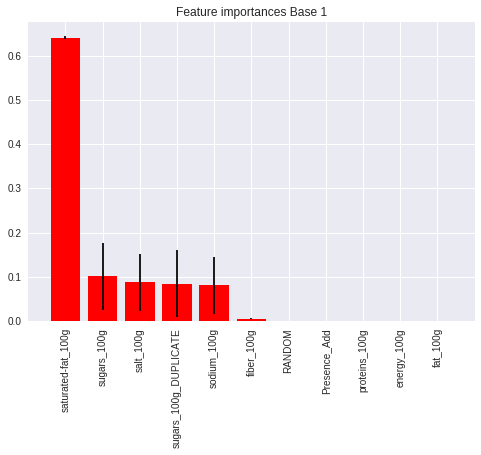

In [49]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances Base 1")
plt.bar(range(X_test_1.shape[1]), 
        importances[indices],
        color="r", 
        yerr=std[indices], 
        align="center")
plt.xticks(range(X_test_1.shape[1]), feat_axis, rotation ='vertical')
plt.xlim([-1, X_test_1.shape[1]])
plt.show()

### Base 2

***The RFC + CV best R² Score with Base 2 is: 0.88 with parameters: {'max_depth': 4, 'n_estimators': 90}***

In [52]:
rfrBest2 = RandomForestRegressor(max_depth= 4, n_estimators= 90)

modelBest2 = rfrBest2.fit(X_train_2, y_train_2)
predBest2 = rfrBest2.predict(X_test_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
print ("The Random Forest Reg Coef R² with Base 2 is:",
       round(rfrBest2.score(X_test_2, y_test_2),3))

The Random Forest Reg Coef R² with Base 2 is: 0.882


In [54]:
importances2 = rfrBest2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfrBest2.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test_2.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train_2.columns[indices2[f]], importances2[indices2[f]]))

Feature ranking:
1. saturated-fat_100g (0.638238)
2. sugars_100g (0.188500)
3. salt_100g (0.167557)
4. fiber_100g (0.005704)


In [55]:
feat_axis2 = []
for f in range(X_test_2.shape[1]):
    feat_axis2.append(X_train_2.columns[indices2[f]])
feat_axis

['saturated-fat_100g',
 'sugars_100g',
 'salt_100g',
 'sugars_100g_DUPLICATE',
 'sodium_100g',
 'fiber_100g',
 'RANDOM',
 'Presence_Add',
 'proteins_100g',
 'energy_100g',
 'fat_100g']

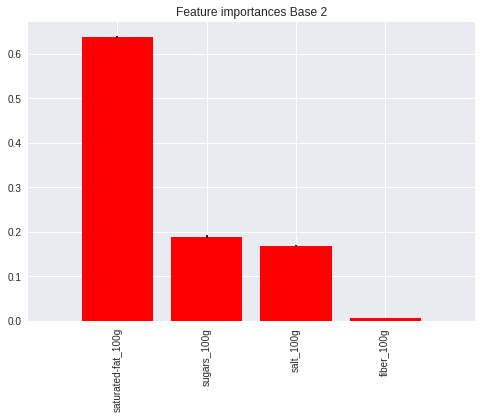

In [56]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances Base 2")
plt.bar(range(X_test_2.shape[1]), 
        importances2[indices2],
        color="r", 
        yerr=std[indices2], 
        align="center")
plt.xticks(range(X_test_2.shape[1]), feat_axis2, rotation ='vertical')
plt.xlim([-1, X_test_2.shape[1]])
plt.show()

# SHAP: predictions explanation

### Base 1 : 

In [0]:
X_train_1s = shap.kmeans(X_train_1, 140)

explainer1 = shap.KernelExplainer(rfrBest1.predict, X_train_1s)
shap_values1 = explainer1.shap_values(X_test_1.iloc[0:1000,:])

In [58]:
shap.initjs()

shap.force_plot(explainer1.expected_value, 
                shap_values1, 
                X_test_1.iloc[0:1000,:])

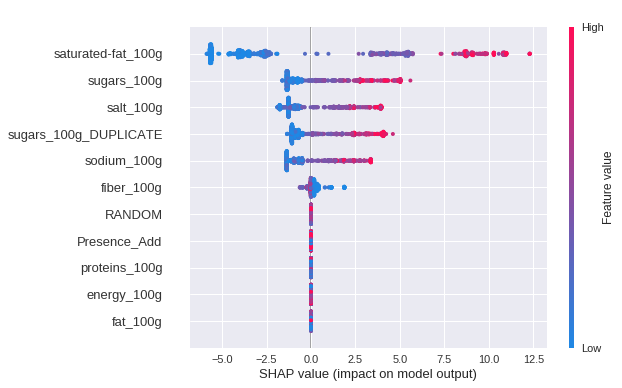

In [59]:
shap.summary_plot(shap_values1, X_test_1.iloc[0:1000, :])

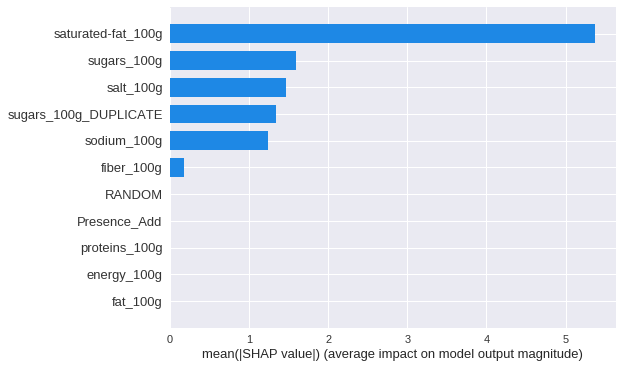

In [60]:
shap.summary_plot(shap_values1, X_test_1.iloc[0:1000, :], plot_type="bar")

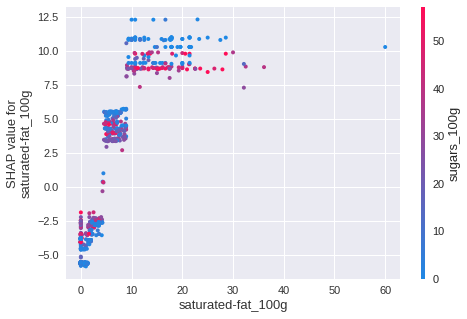

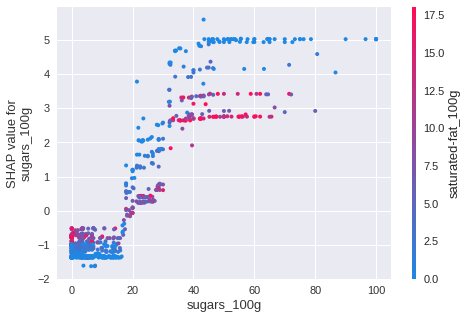

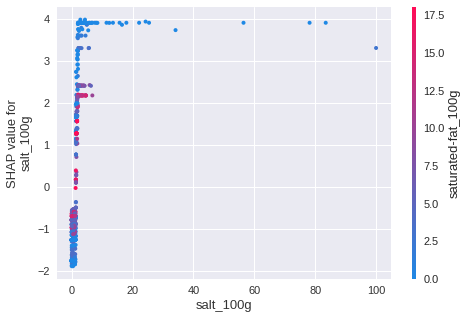

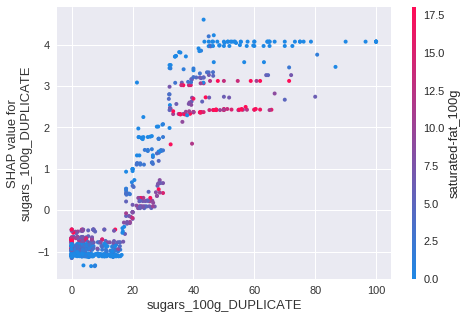

In [67]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values1), 0))

# make SHAP plots of the three most important features
for i in range(4):
    shap.dependence_plot(top_inds[i], shap_values1, X_test_1.iloc[0:1000, :])

### Base 2

In [0]:
X_train_2s = shap.kmeans(X_train_2, 400)

explainer2 = shap.KernelExplainer(rfrBest2.predict, X_train_2s)
shap_values2 = explainer2.shap_values(X_test_2.iloc[0:1000,:])

In [69]:
shap.initjs()

shap.force_plot(explainer2.expected_value, 
                shap_values2, 
                X_test_2.iloc[0:1000,:])

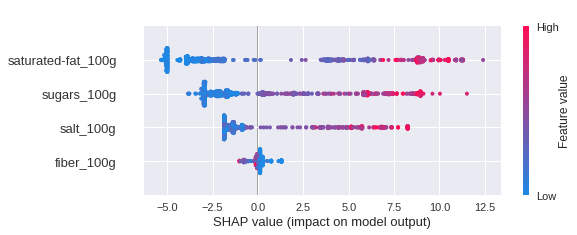

In [70]:
shap.summary_plot(shap_values2, X_test_2.iloc[0:1000, :])

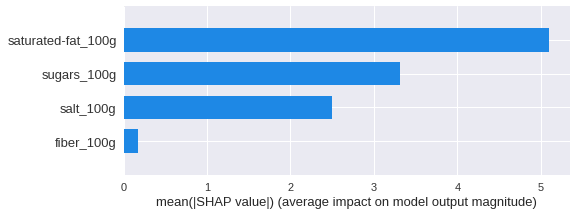

In [71]:
shap.summary_plot(shap_values2, X_test_2.iloc[0:1000, :], plot_type="bar")

### Unique feature

Good Grade

In [116]:
data_nutri_light.loc[54862]

code                                            0042400049531
product_name                               Old Fashioned Oats
additives_n                                                 0
ingredients_from_palm_oil_n                                 0
ingredients_that_may_be_from_palm_oil_n                     0
nutrition_grade_fr                                          a
energy_100g                                              1569
proteins_100g                                            12.5
carbohydrates_100g                                       67.5
sugars_100g                                               2.5
fat_100g                                                  7.5
saturated-fat_100g                                       1.25
fiber_100g                                                 10
salt_100g                                                   0
sodium_100g                                                 0
nutrition-score-fr_100g                                    -5
RANDOM  

In [144]:
X_test_2.loc[54862]

saturated-fat_100g     1.25
sugars_100g            2.50
salt_100g              0.00
fiber_100g            10.00
Name: 54862, dtype: float64

In [114]:
X_test_2.iloc[62]

saturated-fat_100g     1.25
sugars_100g            2.50
salt_100g              0.00
fiber_100g            10.00
Name: 54862, dtype: float64

In [141]:
shap.initjs()

shap_values_single = explainer2.shap_values(X_test_2.iloc[62,:], nsamples=1000)
shap.force_plot(explainer1.expected_value, shap_values_single, X_test_2.iloc[62,:])

Bad Grade

In [137]:
data_nutri_light.loc[121967]

code                                                                0652729121247
product_name                               Elsie Borden, Sweetened Condensed Milk
additives_n                                                                     0
ingredients_from_palm_oil_n                                                     0
ingredients_that_may_be_from_palm_oil_n                                         0
nutrition_grade_fr                                                              e
energy_100g                                                                  1393
proteins_100g                                                                7.69
carbohydrates_100g                                                          56.41
sugars_100g                                                                 56.41
fat_100g                                                                     7.69
saturated-fat_100g                                                           5.13
fiber_100g      

In [138]:
X_test_2.loc[121967]

saturated-fat_100g     5.1300
sugars_100g           56.4100
salt_100g              0.2286
fiber_100g             0.0000
Name: 121967, dtype: float64

In [135]:
X_test_2.iloc[2]

saturated-fat_100g     5.1300
sugars_100g           56.4100
salt_100g              0.2286
fiber_100g             0.0000
Name: 121967, dtype: float64

In [143]:
shap.initjs()

shap_values_single = explainer2.shap_values(X_test_2.iloc[2,:], nsamples=1000)
shap.force_plot(explainer2.expected_value, shap_values_single, X_test_2.iloc[2,:])

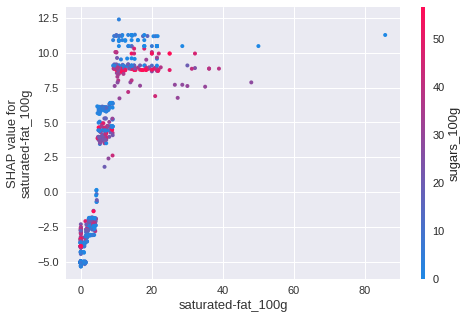

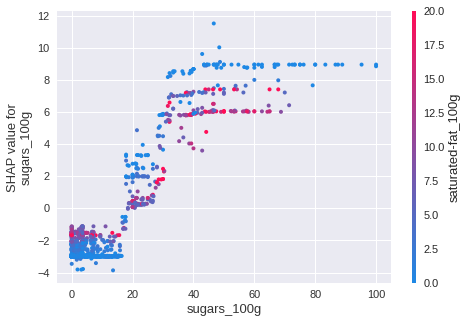

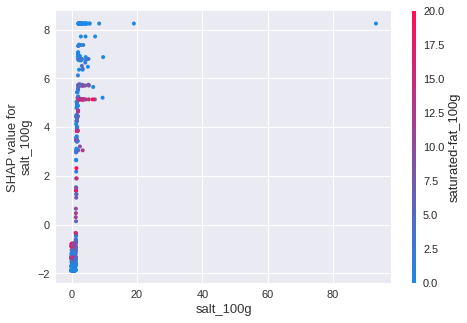

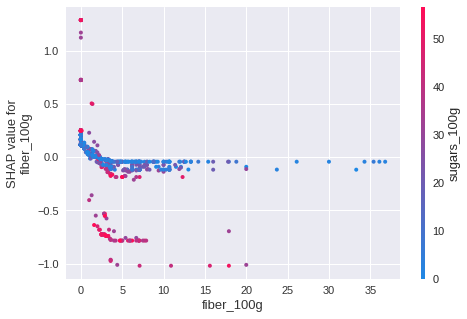

In [78]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds2 = np.argsort(-np.sum(np.abs(shap_values2), 0))

# make SHAP plots of the three most important features
for i in range(4):
    shap.dependence_plot(top_inds2[i], shap_values2, X_test_2.iloc[0:1000, :])